In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from imutils import paths
import matplotlib.pyplot as plt
import shutil
import PIL
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import optimizers
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# **Dataset Loading**

In [2]:
DATASET_PATH="D:/Bachelor/ISIC 2019 Dataset"
TRAINING_PATH=DATASET_PATH+'/Training/Test'
VALIDATION_PATH=DATASET_PATH+'/Validation'
TEST_PATH=DATASET_PATH+'/Test'
GROUND_TRUTH_PATH=DATASET_PATH+'/ISIC_2019_Training_GroundTruth.csv'
data = pd.read_csv(GROUND_TRUTH_PATH, index_col='image')

BENIGN_TRAINING_PATH = TRAINING_PATH+'/0'
MEL_TRAINING_PATH = TRAINING_PATH+'/1'

BENIGN_TRAINING_PATHS = sorted(paths.list_images(BENIGN_TRAINING_PATH))
print("Working with {0} non-melanoma images".format(len(BENIGN_TRAINING_PATHS)))

MEL_TRAINING_PATHS = [f for f in sorted(paths.list_images(MEL_TRAINING_PATH))]
print("Working with {0} melanoma images".format(len(MEL_TRAINING_PATHS)))

Working with 10851 non-melanoma images
Working with 7234 melanoma images


## **Dataset Testing**

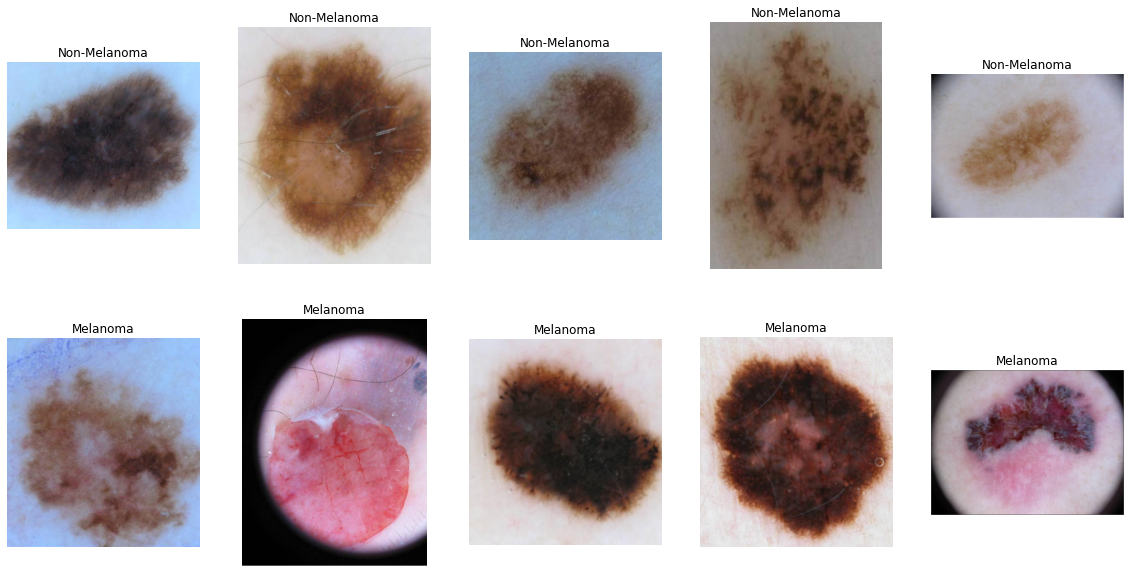

In [3]:
plt.figure(figsize=(20, 10))
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(PIL.Image.open(BENIGN_TRAINING_PATHS[i]))
    plt.title("Non-Melanoma")
    plt.axis("off")
    ax = plt.subplot(2, 5, i + 1+5)
    plt.imshow(PIL.Image.open(MEL_TRAINING_PATHS[i]))
    plt.title("Melanoma")
    plt.axis("off")

# **InceptionResNetV2**

## **Building the Model**

In [3]:
size=112
base = tf.keras.applications.EfficientNetB7(input_shape=(size,size,3), weights='imagenet', include_top=False)

base.trainable = False

# Create new model on top
inputs = keras.Input(shape=(size, size, 3), dtype=np.float16)
x=inputs
x=base(x,training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(2,activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 4, 4, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 5122      
Total params: 64,102,809
Trainable params: 5,122
Non-trainable params: 64,097,687
_________________________________________________________________


## Building training and validation datasets

In [4]:
from tensorflow.keras.applications.efficientnet import preprocess_input
batch=160
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_set = validation_datagen.flow_from_directory(VALIDATION_PATH,(size,size),batch_size=batch,
                                                 class_mode = 'categorical')
train_set = train_datagen.flow_from_directory(TRAINING_PATH,(size,size),batch_size=batch,
                                                 class_mode = 'categorical')

Found 2533 images belonging to 2 classes.
Found 18085 images belonging to 2 classes.


## **Training the top layer**

In [5]:
callbacks = [ModelCheckpoint(filepath=DATASET_PATH+'/model/EfficientNet', 
                               verbose=1, save_best_only=True),
            EarlyStopping(monitor='val_loss', patience=10, mode='min', min_delta=0.0001, restore_best_weights=True)]

start = datetime.now()

model_history=model.fit(
  train_set,
  validation_data=validation_set,
  epochs=50,
    callbacks=callbacks ,verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50


KeyboardInterrupt: 

## **Fine-tuning the entire model**

In [4]:
model = keras.models.load_model(DATASET_PATH+'/model/EfficientNet')
model.layers[1].trainable=True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  
    loss='binary_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [4]:
from tensorflow.keras.applications.efficientnet import preprocess_input
batch=8
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_set = validation_datagen.flow_from_directory(VALIDATION_PATH,(size,size),batch_size=batch,
                                                 class_mode = 'categorical')
train_set = train_datagen.flow_from_directory(TRAINING_PATH,(size,size),batch_size=batch,
                                                 class_mode = 'categorical')

Found 2533 images belonging to 2 classes.
Found 18085 images belonging to 2 classes.


In [7]:
callbacks = [ModelCheckpoint(filepath=DATASET_PATH+'/model/EfficientNet/Fine Tuned/{epoch:02d}.h5', 
                               verbose=1, save_freq=5*2261)]

start = datetime.now()

model_history=model.fit(
  train_set,
  batch_size=batch,
  validation_data=validation_set,
  epochs=30,
    callbacks=callbacks ,verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/30
2261/2261 [==============================] - 899s 397ms/step - loss: 0.4175 - binary_accuracy: 0.8060 - val_loss: 0.3903 - val_binary_accuracy: 0.8338
Epoch 2/30
2261/2261 [==============================] - 947s 419ms/step - loss: 0.3450 - binary_accuracy: 0.8450 - val_loss: 0.3144 - val_binary_accuracy: 0.8737
Epoch 3/30
2261/2261 [==============================] - 959s 424ms/step - loss: 0.2979 - binary_accuracy: 0.8680 - val_loss: 0.3240 - val_binary_accuracy: 0.8618
Epoch 4/30
2261/2261 [==============================] - 973s 430ms/step - loss: 0.2607 - binary_accuracy: 0.8843 - val_loss: 0.2757 - val_binary_accuracy: 0.8867
Epoch 5/30
2261/2261 [==============================] - ETA: 0s - loss: 0.2211 - binary_accuracy: 0.9031
Epoch 00005: saving model to D:/Bachelor/ISIC 2019 Dataset/model/EfficientNet/Fine Tuned\05.h5


c:\program files\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


2261/2261 [==============================] - 966s 427ms/step - loss: 0.2211 - binary_accuracy: 0.9031 - val_loss: 0.3414 - val_binary_accuracy: 0.8535
Epoch 6/30
2261/2261 [==============================] - 966s 427ms/step - loss: 0.1930 - binary_accuracy: 0.9171 - val_loss: 0.2803 - val_binary_accuracy: 0.8883
Epoch 7/30
2261/2261 [==============================] - 859s 380ms/step - loss: 0.1617 - binary_accuracy: 0.9315 - val_loss: 0.2882 - val_binary_accuracy: 0.8887
Epoch 8/30
2261/2261 [==============================] - 842s 373ms/step - loss: 0.1323 - binary_accuracy: 0.9449 - val_loss: 0.3099 - val_binary_accuracy: 0.8910
Epoch 9/30
2261/2261 [==============================] - 846s 374ms/step - loss: 0.1111 - binary_accuracy: 0.9548 - val_loss: 0.2948 - val_binary_accuracy: 0.9021
Epoch 10/30
2261/2261 [==============================] - ETA: 0s - loss: 0.0968 - binary_accuracy: 0.9619
Epoch 00010: saving model to D:/Bachelor/ISIC 2019 Dataset/model/EfficientNet/Fine Tuned\10.h5


## **Testing the model**

In [5]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_set = test_datagen.flow_from_directory(TEST_PATH,(size,size), batch_size=4,shuffle=False,
                                                 class_mode = 'categorical')
for j in range(5,31,5):
    model = keras.models.load_model(DATASET_PATH+'/model/EfficientNet/Fine Tuned/'+str(j).zfill(2)+'.h5')
    result = model.predict(test_set, verbose=1)
    res=np.argmax(result, axis=1)
    names=test_set.filenames
    tp=0
    tn=0
    fp=0
    fn=0

    for i in range(len(names)):
      gt = names[i][0]
      filename = names[i][2:-4]
      if res[i]==0:
        if gt=='0':
          tn+=1
        else:
          fn+=1
      else:
        if gt=='0':
          fp+=1
        else:
          tp+=1
    sensitivity = round(tp*100/(tp+fn),2)
    specifity = round(tn*100/(tn+fp),2)
    accuracy = round((tp+tn)*100/(tn+tp+fn+fp),2)
    balancedAccuracy= round((sensitivity+specifity)/2,2)
    
    print(j,':')
    print(tp)
    print(tn)
    print(fp)
    print(fn)
    print('sensitivity: ',sensitivity,'%')
    print('specifity: ',specifity,'%')
    print('accuracy: ',accuracy,'%')
    print('balanced accuracy',balancedAccuracy, '%')

Found 2534 images belonging to 2 classes.
634/634 [==============================] - 42s 58ms/step
5 :
300
1911
170
153
sensitivity:  66.23 %
specifity:  91.83 %
accuracy:  87.25 %
balanced accuracy 79.03 %
634/634 [==============================] - 40s 58ms/step
10 :
317
1949
132
136
sensitivity:  69.98 %
specifity:  93.66 %
accuracy:  89.42 %
balanced accuracy 81.82 %
634/634 [==============================] - 39s 57ms/step
15 :
325
1972
109
128
sensitivity:  71.74 %
specifity:  94.76 %
accuracy:  90.65 %
balanced accuracy 83.25 %
634/634 [==============================] - 42s 61ms/step
20 :
332
1939
142
121
sensitivity:  73.29 %
specifity:  93.18 %
accuracy:  89.62 %
balanced accuracy 83.24 %


ResourceExhaustedError: OOM when allocating tensor with shape[224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill]

In [ ]:
model = keras.models.load_model(DATASET_PATH+'/model/NasNetLarge/Fine Tuned')
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
test_set = train_datagen.flow_from_directory(TEST_PATH,(size,size), batch_size=16,shuffle=False,
                                                 class_mode = 'categorical')
result = model.predict(test_set)

In [ ]:
res=np.argmax(result, axis=1)
names=test_set.filenames
tp=0
tn=0
fp=0
fn=0
for i in range(len(names)):
  gt = names[i][0]
  filename = names[i][2:-4]
  if res[i]==0:
    if gt=='0':
      tn+=1
    else:
      fn+=1
  else:
    if gt=='0':
      fp+=1
    else:
      tp+=1
sensitivity = round(tp*100/(tp+fn),2)
specifity = round(tn*100/(tn+fp),2)
accuracy = round((tp+tn)*100/(tn+tp+fn+fp),2)

print(tp)
print(tn)
print(fp)
print(fn)
print('sensitivity: ',sensitivity,'%')
print('specifity: ',specifity,'%')
print('accuracy: ',accuracy,'%')

## **Model Statistics**

In [ ]:
_# Plot training & validation loss values
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()